# Building a Decision Using the Decision Science Framework

The goal of the Decision Science Framework (DSF) is to provide a general, but accessible framework to ease the burdon of using quantitative decision making methods. This short tutorial will walk through the creation of a decision using the DSF from scratch.  We'll take this process all the way through to the measurement of information values. 

In [1]:
from DecisionScienceFramework.decision import Decision
# Initialize the decision object with a name and fp where we'll save our progress
school_decision = Decision("School Decision", fp="C:\\Users\\perus\\GitHub\\Decision-Science-Framework")

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\botworks\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Recreating the Decision Model sample

In this decision we are choosing between two different recruitment strategies.  We might either hire new staff to actively recuit folks through different engagement strategies, or we could employ a digital media strategy that doesn't actually require more staff but has costs involved in purchasing the service.

The base cost for either strategy is $1,000,000.  For each strategy we then want to consider the probability that we are over/under budget and the effictiveness of either strategy.

In [2]:
# For the hiring strategy, we consider the distribution that we are over/under the base 
# cost.  So in this case, we might be $20,000 under or $400,000 over.
school_decision.add_variable_from_ci("HiringCostOver", lower=-100000, upper=400000, dist="Normal")
# We also want to capture their effectiveness
school_decision.add_variable_from_ci("HiringEffectiveness", lower=30, upper=300, mode=80, dist="Lognormal")

Optimization terminated successfully.
         Current function value: 569.337410
         Iterations: 105
         Function evaluations: 202


In [3]:
# Okay, now we want to create similar variables but for the digital marketing strategy
school_decision.add_variable_from_ci("MarketingCostOver", lower=-20000, upper=80000, dist="Normal")
school_decision.add_variable_from_ci("MarketingEffectiveness", lower=45, upper=90, mode=60, dist="Lognormal")

Optimization terminated successfully.
         Current function value: 16.394315
         Iterations: 88
         Function evaluations: 173


In [4]:
# Now that we've established costs and effectiveness, we just need to add someway to translate
# the number of additional ACMs recruited to a monetary value 
school_decision.add_variable_from_ci("ACMValueAdd", lower=3000, upper=48000, mode=9200, dist='Lognormal')

Optimization terminated successfully.
         Current function value: 17309836.200198
         Iterations: 127
         Function evaluations: 248


In [5]:
# These are the last of our random variables.  Before defining any further deterministic variables,
# like the loss function, we will need to sample.
school_decision.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\botworks\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [ACMValueAdd_log__, MarketingEffectiveness_log__, MarketingCostOver, HiringEffectiveness_log__, HiringCostOver]
100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:07<00:00, 757.09it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [6]:
school_decision.add_variable_from_patsy("HireCost", "-1000000 - HiringCostOver")
school_decision.add_variable_from_patsy("HireBenefit", "ACMValueAdd * HiringEffectiveness")
school_decision.add_variable_from_patsy("HireNet", "HireCost + HireBenefit")

In [7]:
school_decision.add_variable_from_patsy("MarketingCost", "-1000000 - MarketingCostOver")
school_decision.add_variable_from_patsy("MarketingBenefit", "ACMValueAdd * MarketingEffectiveness")
school_decision.add_variable_from_patsy("MarketingNet", "MarketingCost + MarketingBenefit")

In [8]:
# Our choice of loss functions builds in our default choice.  By convention, we want to minimize loss.  Therefore high values 
# of loss are undesirable.  So, if our default decision is to Hire.  Then the opportunity loss is expressed by any beneft that
# Marketing may have had over Hiring. 
school_decision.set_loss("MarketingNet - HireNet")

In [9]:
from math import ceil
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def plot_variables(samples):
    cols = samples.columns
    ncols = len(cols)
    if ncols <= 8:
        grid_cols = 2
        grid_rows = ceil(ncols/2)       
    else:
        grid_cols = 3
        grid_rows = ceil(ncols/3)
    
    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(30, 30))
    for ix, coord in enumerate(product(range(0, grid_rows), range(0, grid_cols))):
        try:
            axs[coord].hist(samples[cols[ix]], bins=50)
            axs[coord].set_xlabel(cols[ix])
            #axs[coord].rc("axes", titlesize=20)
        except:
            pass
    
    plt.show()

In [ ]:
school_decision.plot_

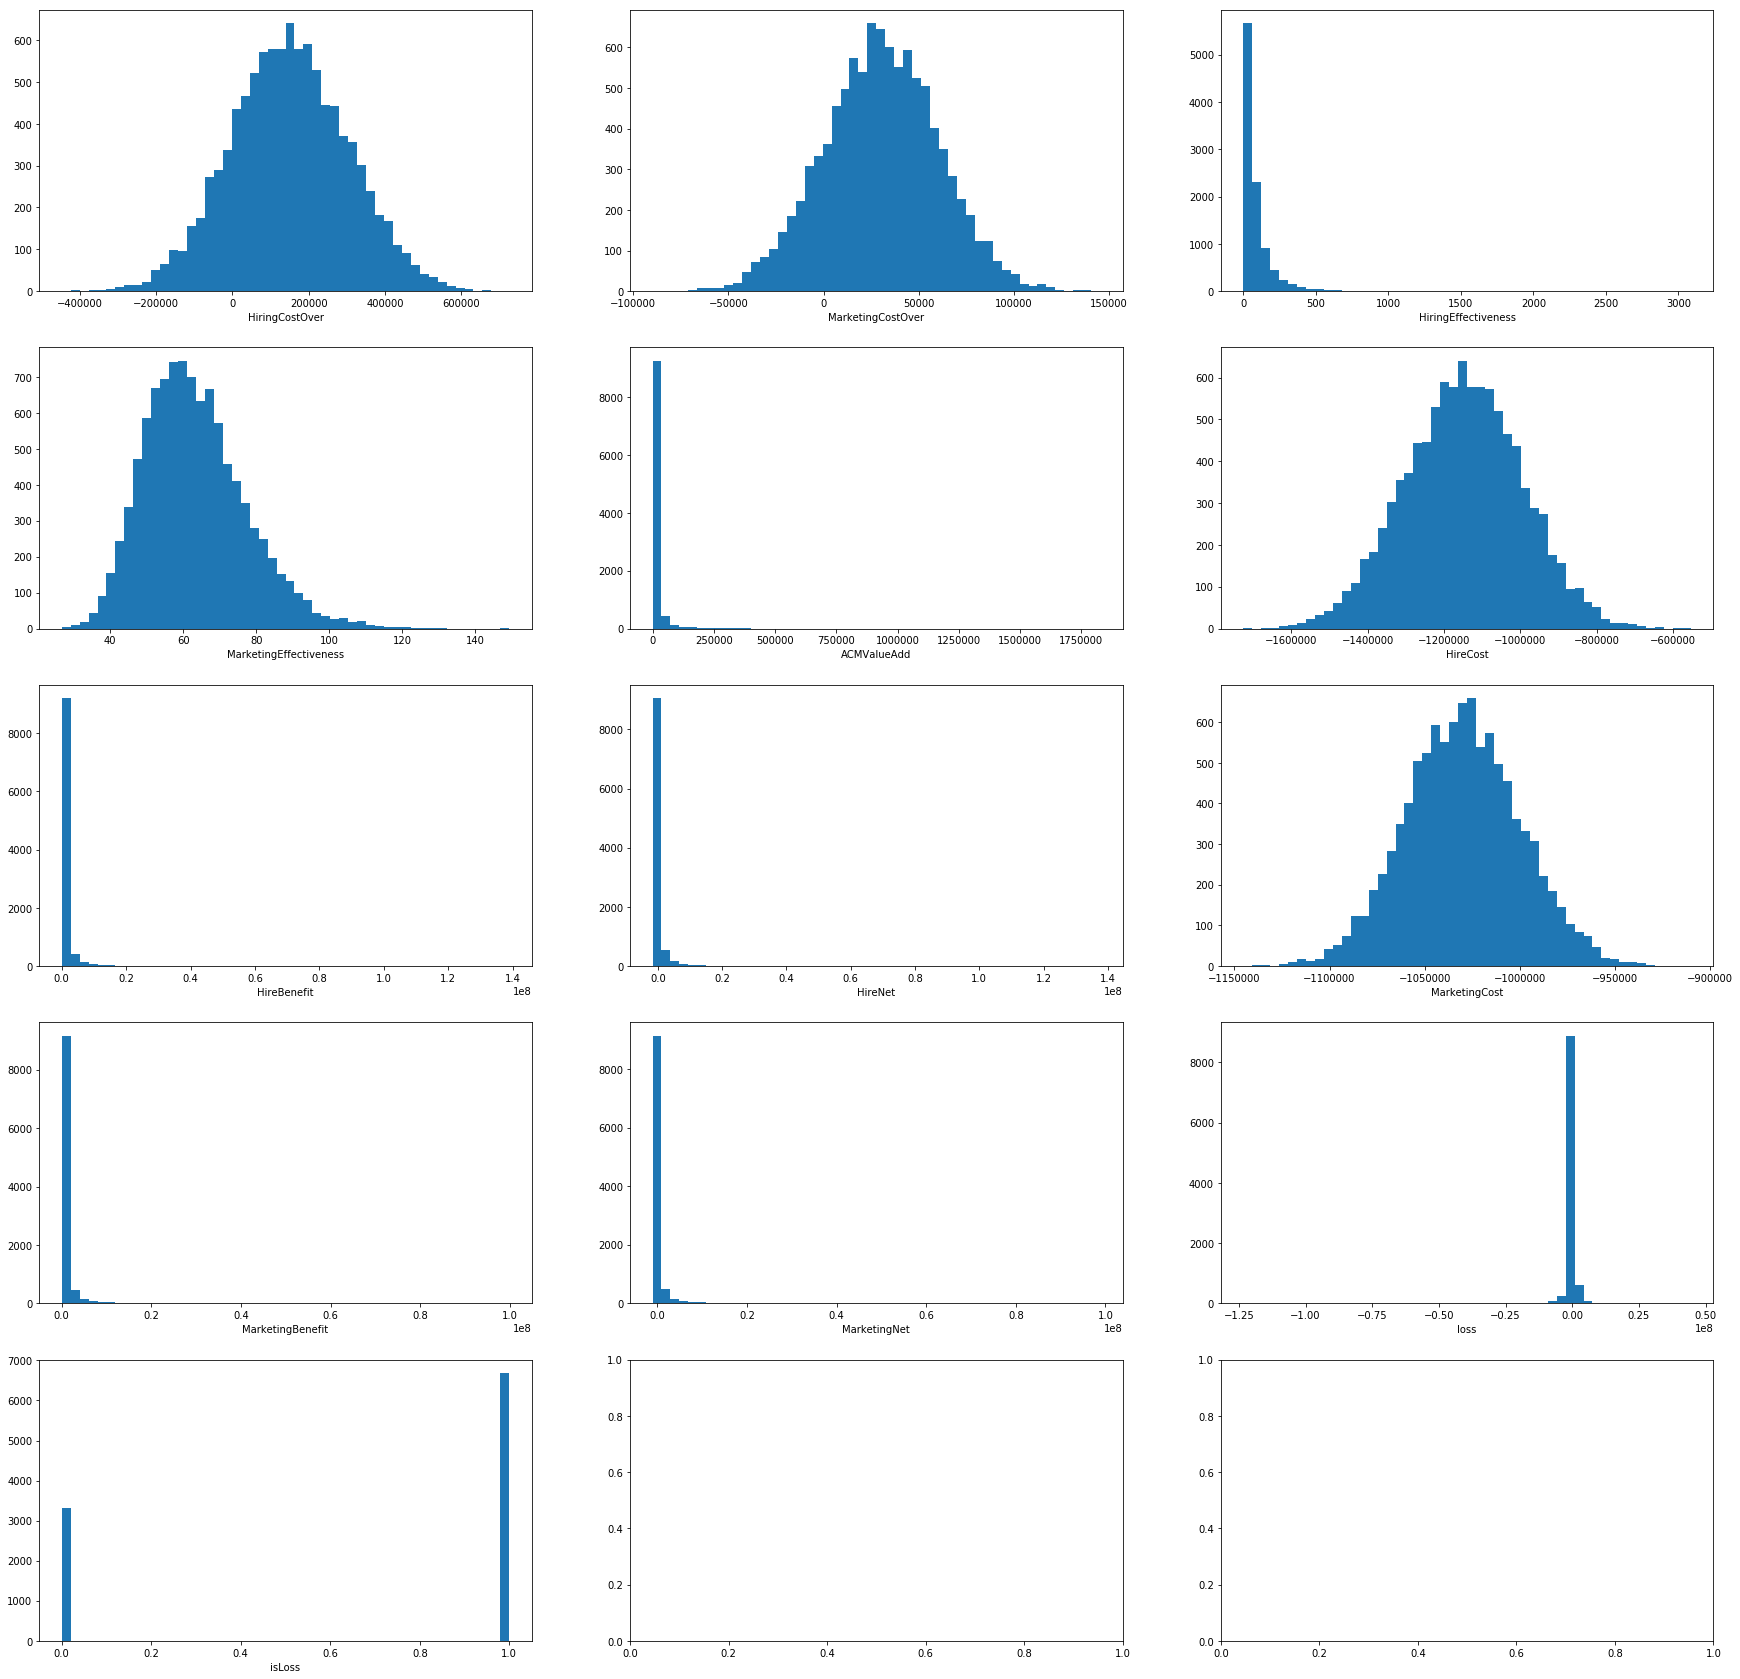

In [10]:
plot_variables(school_decision.last_run)

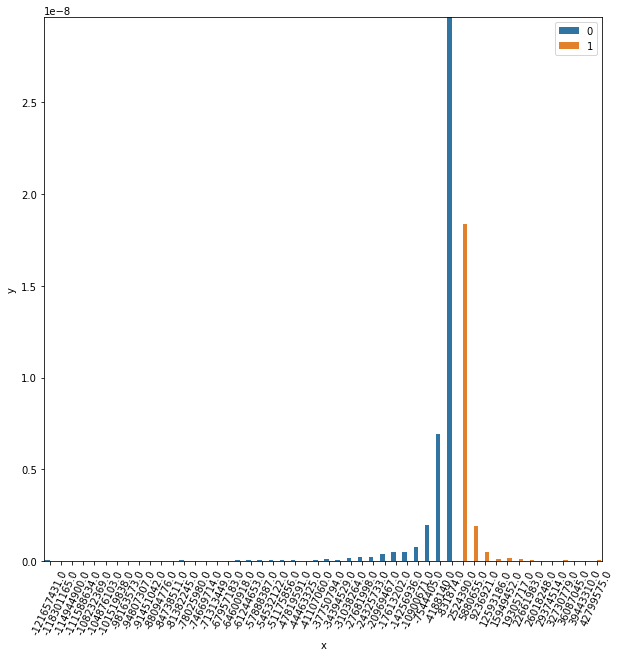

In [11]:
# Many negative options means that 
school_decision.plot_loss()

In [13]:
school_decision.evpi()

NameError: name 'school_decision' is not defined

In [11]:
import patsy 
import numpy as np

def calculate_info_value(run_data, column):
    baseline_uncertainty = eol(run_data)
    mu = run_data[column].mean()
    fixed = run_data.copy()
    fixed[column] = mu
    for key, item in school_decision.deterministic.items():
        var = patsy.dmatrix(f"I({item}) - 1", data=fixed)
        fixed[key] = np.asarray(var)
    updated_uncertainty = eol(fixed)
    return baseline_uncertainty - updated_uncertainty

In [12]:
def eol(last_run):
    """Calculate the Expected Opportunity Loss for a given set of samples
    
    First we consider the Expected Loss over our sample. This indicates what our "default" position should be. If 
    it is negative (which corresponds to a positive outcome), then we decide to accepting the proposal.  Otherwise if the
    expected loss is positive, then we default to declining the proposal.  Given that default, the Expected Opportunity
    Loss is thus the average outcome if we had done the opposite.  So we sum up the losses where, if we accepted the proposal, 
    then that declining the proposal would have actually been the right decision and divide that over the total number of
    simulations considered.
    """
    exp_loss = last_run.loss.mean()
    if exp_loss < 0:
        return sum(last_run[last_run.loss > 0].loss) / last_run.shape[0]
    else:
        return sum(last_run[last_run.loss < 0].loss) / last_run.shape[0]

In [15]:
school_decision.last_run.loss.mean()

-229100.0707182531

In [16]:
eol(school_decision.last_run)

337782.2634110025

In [17]:
for column in school_decision.random.keys():
    print(f"{column}: {calculate_info_value(school_decision.last_run, column)}")

HiringCostOver: 11886.700369513419
HiringEffectiveness: 264060.8007595005
MarketingCostOver: 798.9030622472055
MarketingEffectiveness: 8241.121902626997
ACMValueAdd: 19242.646484908415


In [52]:
eol(school_decision.last_run)

482912.7541221414

In [34]:
school_decision.last_run.loss.mean()

-292242.0700211502

In [39]:
# Probability of loss given that we choose Marketing
school_decision.last_run.isLoss.mean()

0.34

In [31]:
# Total loss given that we choose Marketing
school_decision.last_run[school_decision.last_run.isLoss == 1].loss.mean()

-1831508.1008010048

In [32]:
# Total loss given that we choose Marketing
school_decision.last_run[school_decision.last_run.isLoss == 0].loss.mean()

500713.15795634745

In [24]:
school_decision.last_run.loss.mean()

-292242.0700211502

In [112]:
school_decision.last_run.loss.mean()

-251310.60329063085

In [14]:
school_decision.last_run.loss.std()

5144533.42696141

In [55]:
def get_interval(alpha, samples):
    loss_vec = samples.sort_values('loss', ascending=True).loss
    min_ix = int(loss_vec.shape[0]*alpha)
    max_ix = int(loss_vec.shape[0]*(1-alpha))
    return loss_vec.iloc[min_ix], loss_vec.iloc[max_ix]  

In [57]:
get_interval(0.05, school_decision.last_run)

(-1901594.7774178819, 1073680.9680925482)